In [1]:
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.sparse import coo_matrix
import astropy.wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs.utils import pixel_to_skycoord
from astropy.io import fits
from astropy.wcs import WCS
from scipy.interpolate import UnivariateSpline

Tcmb=2.725
k_B = 1.38E-23

In [2]:
print 'start @ ' + time.asctime(time.localtime(time.time())) +'...'

start @ Wed Jul  8 20:31:05 2020...


In [3]:
def cal_freq(ch):
    v_min=856.0 
    v_max=1712.0 
    dv=0.208984375
    assert((v_max-v_min)/dv==4096)
    freq_MHz=ch*dv+v_min
    freq=freq_MHz*1e6
    return freq

In [4]:
pix_deg=0.3
std_sigma=2.5 #the smaller number will make more data be delated 

ch_plot=800

In [5]:
p_radec=np.loadtxt('radio_source.txt')
ptr_pix=np.loadtxt('radio_source_pix_'+str(pix_deg)+'deg.txt')
ptr_ra_pix,ptr_dec_pix=ptr_pix[:,0],ptr_pix[:,1]
output_file='./'

In [6]:
fname_list=['1551037708','1551055211','1553966342','1554156377','1556052116','1556138397','1562857793']

# try to load merged but unfiltered data

In [7]:
total_count_MAX=371 #371 in total for level5 result
niter=3

>>>>>>>>> Iteration 0 start...
(133, 41, 4096)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : 143.0  -2.5  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 4096  41  133
(133, 41, 4096)


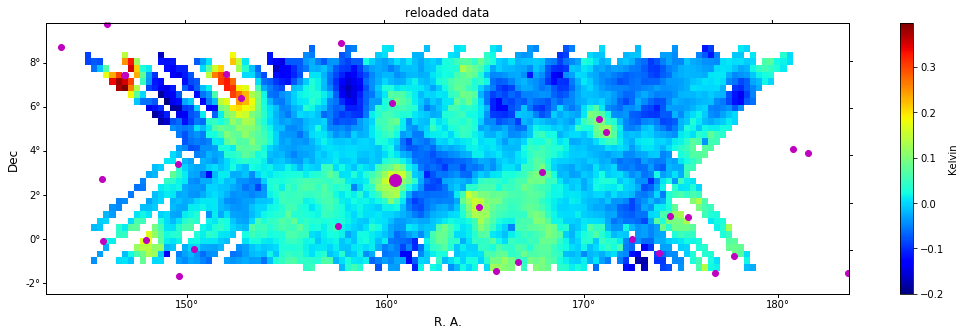

-0.201413249477 0.397550378799
-0.011552533827 0.0482343426318


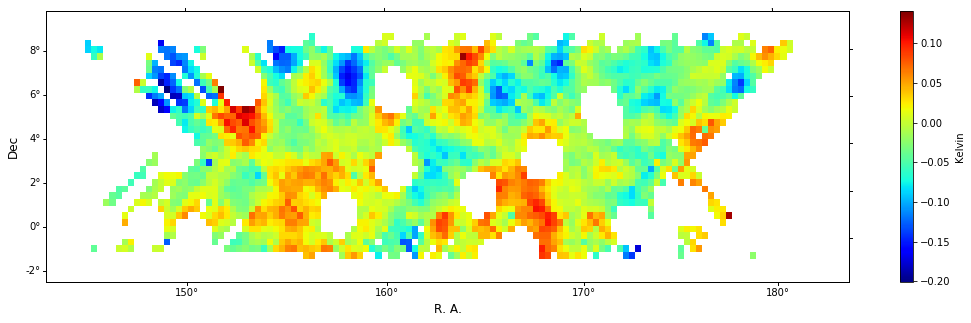

/usr/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:76: RuntimeWarning: Mean of empty slice


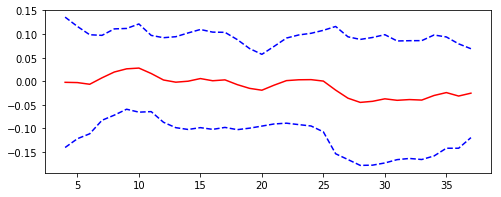

-------------------------------------------
-------------------------------------------
***stastic cubes initialized
# cube 1: 1551037708 m000


/usr/lib/python2.7/dist-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


***930 channels deleted
***455 channels left
# cube 2: 1551055211 m000
***272 channels deleted
***1129 channels left
# cube 3: 1553966342 m000
***1367 channels deleted
***65 channels left
# cube 4: 1554156377 m000
***48 channels deleted
***1391 channels left
# cube 5: 1556052116 m000
***379 channels deleted
***782 channels left
# cube 6: 1556138397 m000
***849 channels deleted
***592 channels left
no data cube for 1562857793, m000
no data cube for 1551037708, m001
# cube 7: 1551055211 m001
***531 channels deleted
***856 channels left
# cube 8: 1553966342 m001
***1245 channels deleted
***162 channels left
# cube 9: 1554156377 m001
***1084 channels deleted
***352 channels left
# cube 10: 1556052116 m001
***873 channels deleted
***102 channels left
# cube 11: 1556138397 m001
***1329 channels deleted
***112 channels left
no data cube for 1562857793, m001
# cube 12: 1551037708 m002
***6 channels deleted
***1395 channels left
# cube 13: 1551055211 m002
***17 channels deleted
***1394 channels

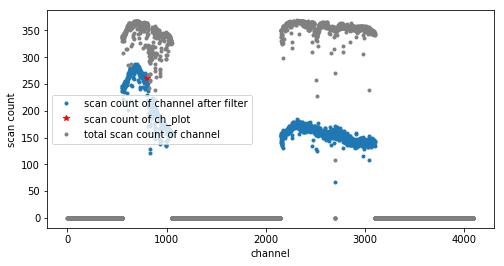

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:237: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:238: RuntimeWarning: invalid value encountered in divide


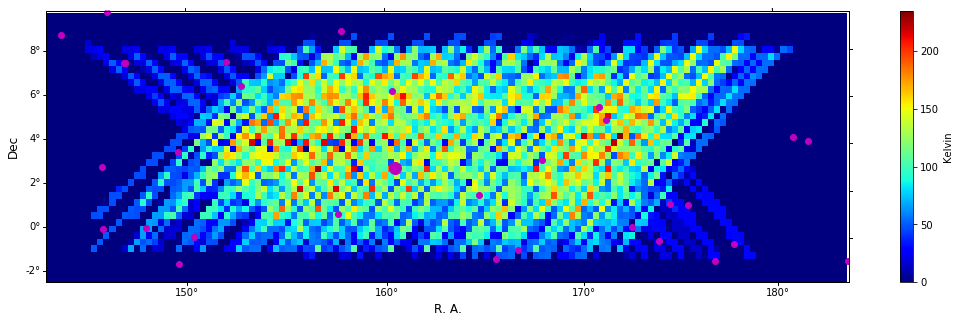

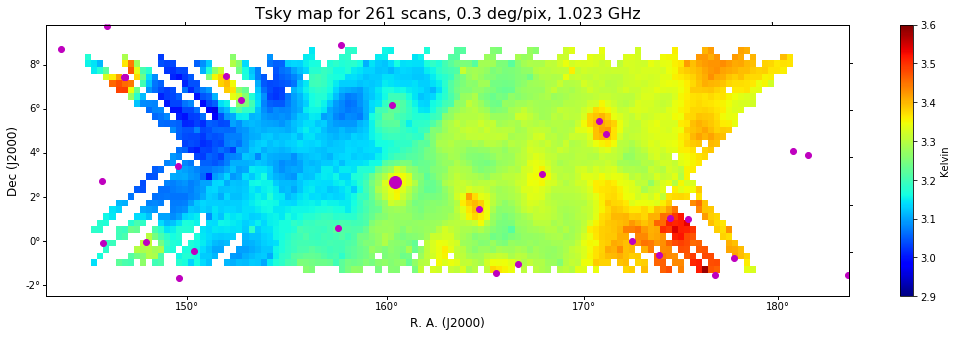

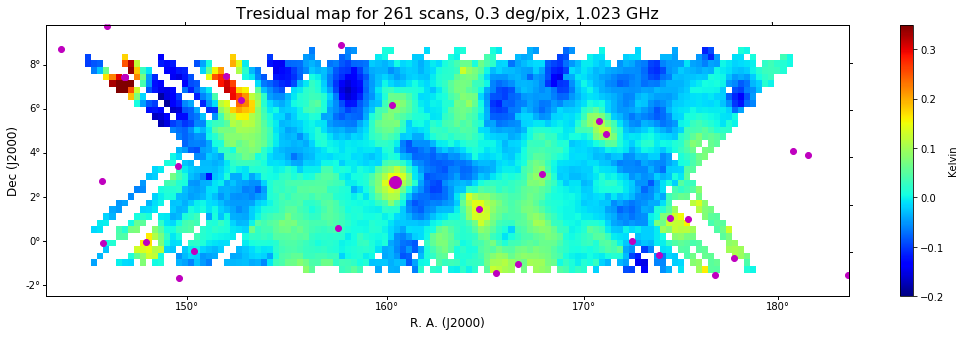

371
>>>>>>>>> Iteration 1 start...
(133, 41, 4096)


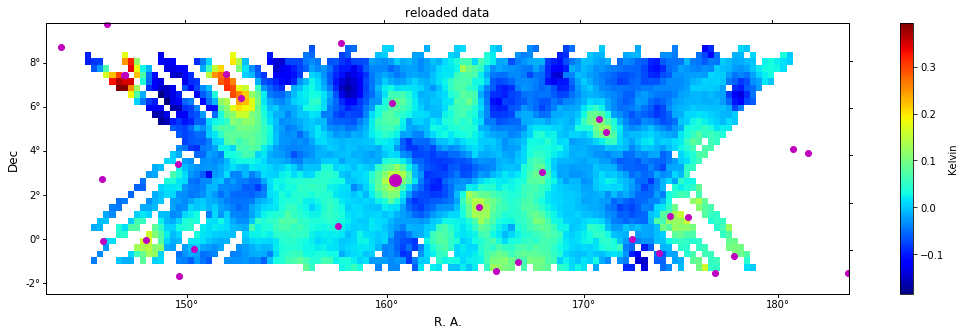

-0.186239393391 0.394497147504
-0.0113915000506 0.047056369155


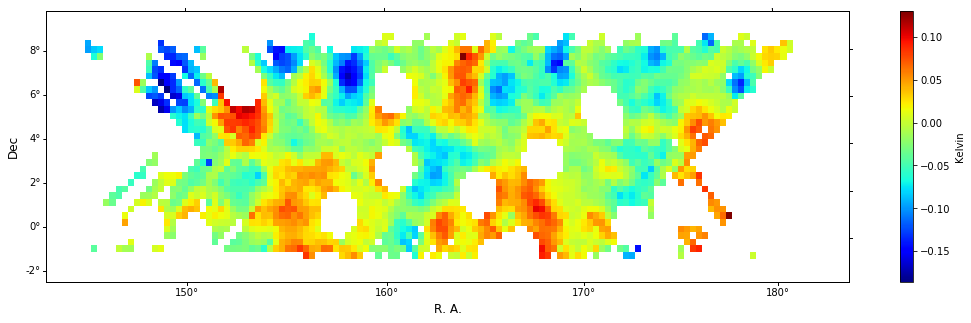

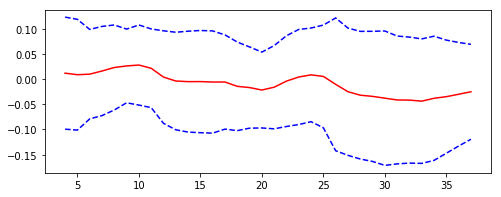

-------------------------------------------
-------------------------------------------
***stastic cubes initialized
# cube 1: 1551037708 m000
***996 channels deleted
***389 channels left
# cube 2: 1551055211 m000
***477 channels deleted
***924 channels left
# cube 3: 1553966342 m000
***1391 channels deleted
***41 channels left
# cube 4: 1554156377 m000
***204 channels deleted
***1235 channels left
# cube 5: 1556052116 m000
***849 channels deleted
***312 channels left
# cube 6: 1556138397 m000
***1105 channels deleted
***336 channels left
no data cube for 1562857793, m000
no data cube for 1551037708, m001
# cube 7: 1551055211 m001
***955 channels deleted
***432 channels left
# cube 8: 1553966342 m001
***1263 channels deleted
***144 channels left
# cube 9: 1554156377 m001
***1136 channels deleted
***300 channels left
# cube 10: 1556052116 m001
***877 channels deleted
***98 channels left
# cube 11: 1556138397 m001
***1332 channels deleted
***109 channels left
no data cube for 1562857793,

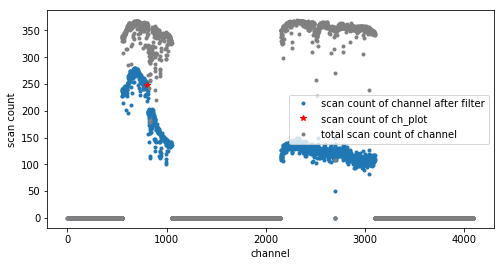

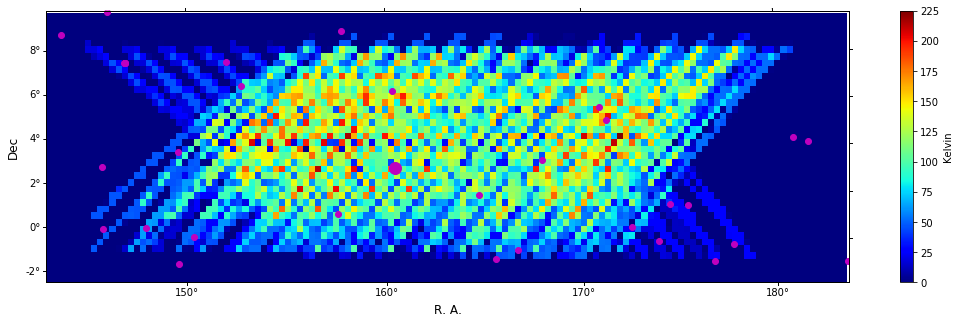

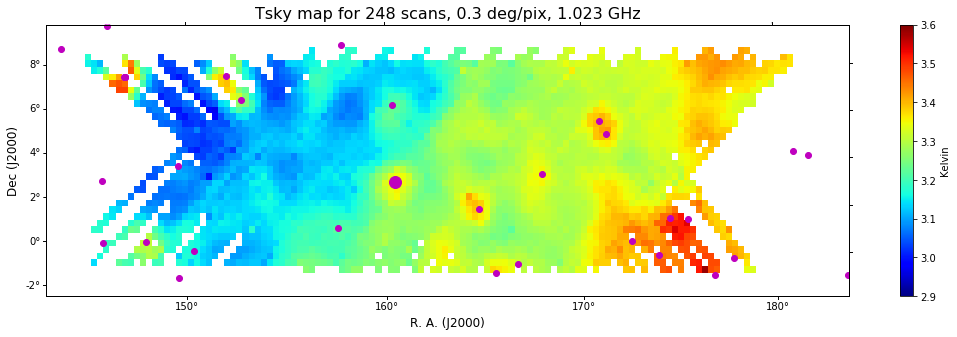

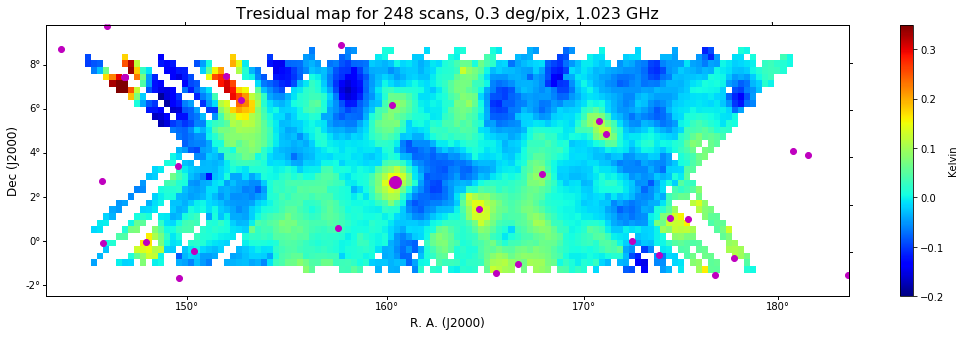

371
>>>>>>>>> Iteration 2 start...
(133, 41, 4096)


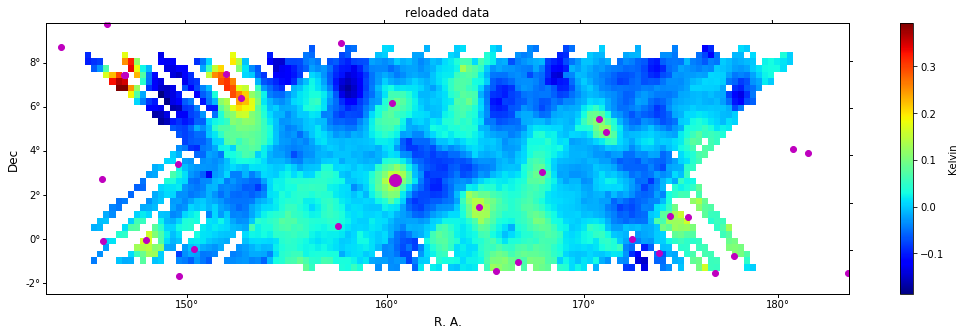

-0.187159487029 0.39310009651
-0.0113412883398 0.0470234964925


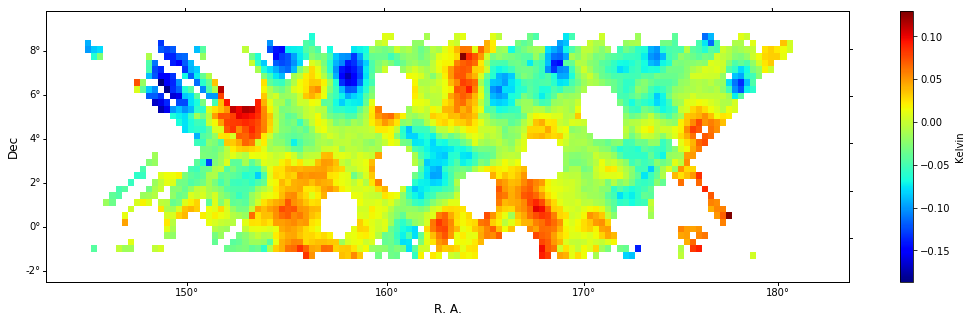

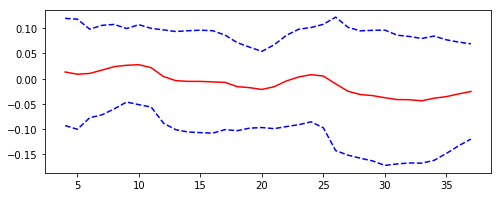

-------------------------------------------
-------------------------------------------
***stastic cubes initialized
# cube 1: 1551037708 m000
***1020 channels deleted
***365 channels left
# cube 2: 1551055211 m000
***433 channels deleted
***968 channels left
# cube 3: 1553966342 m000
***1394 channels deleted
***38 channels left
# cube 4: 1554156377 m000
***507 channels deleted
***932 channels left
# cube 5: 1556052116 m000
***875 channels deleted
***286 channels left
# cube 6: 1556138397 m000
***1121 channels deleted
***320 channels left
no data cube for 1562857793, m000
no data cube for 1551037708, m001
# cube 7: 1551055211 m001
***969 channels deleted
***418 channels left
# cube 8: 1553966342 m001
***1265 channels deleted
***142 channels left
# cube 9: 1554156377 m001
***1151 channels deleted
***285 channels left
# cube 10: 1556052116 m001
***877 channels deleted
***98 channels left
# cube 11: 1556138397 m001
***1333 channels deleted
***108 channels left
no data cube for 1562857793,

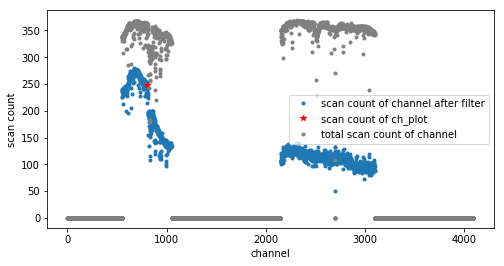

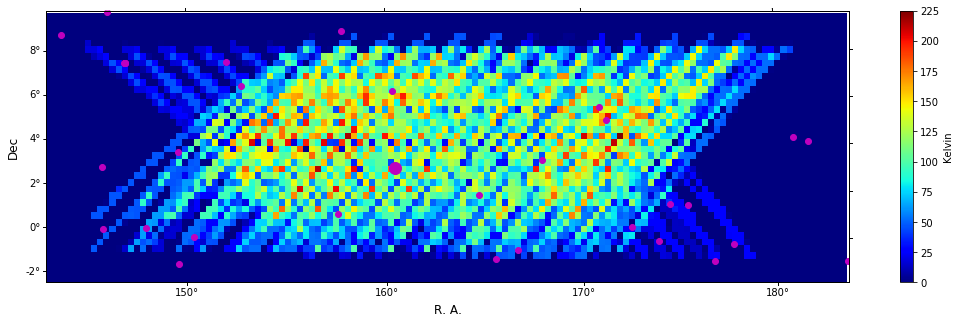

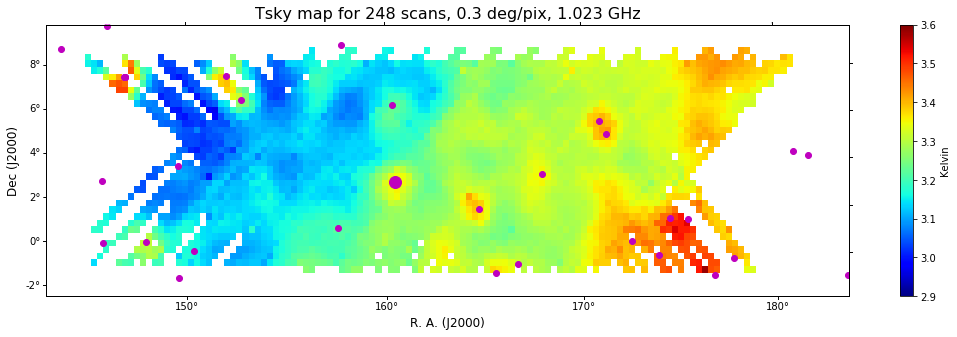

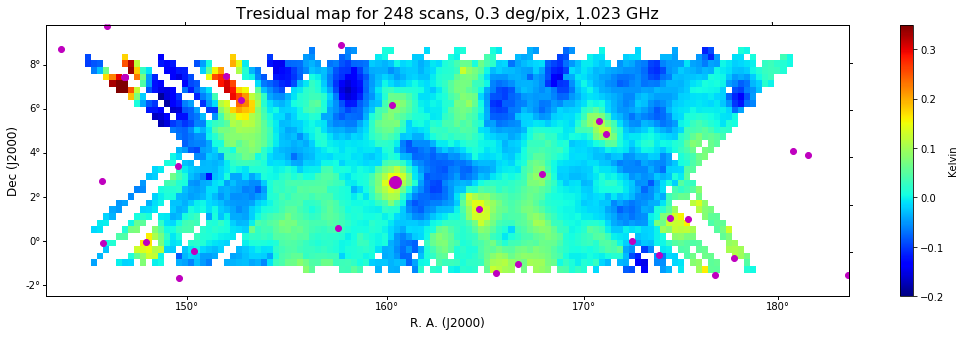

371


In [8]:
pix_ma_ra=[]
pix_ma_dec=[]

for i_iter in range(niter):
    print '>>>>>>>>> Iteration '+str(i_iter)+' start...'
    
    ####load previous data in########
    try:
        if i_iter==0:#First
            Fits=output_file+'ALL_scan'+str(total_count_MAX)+'_Tresi_cube_p'+str(pix_deg)+'d.fits'
            Tresi_cube = fits.open(Fits)[0].data
            print np.shape(Tresi_cube)
            #only need to load once###
            Npix_x= np.shape(Tresi_cube)[0]
            Npix_y= np.shape(Tresi_cube)[1]

            w2=WCS(Fits).dropaxis(-1)
            print w2
            
            ####mask point sources######    
            map_ra=np.zeros_like(Tresi_cube[:,:,ch_plot])
            map_dec=np.zeros_like(Tresi_cube[:,:,ch_plot])
            for i in range(np.shape(map_ra)[0]):
                for j in range(np.shape(map_ra)[1]):
                    radec=pixel_to_skycoord(i,j,w2)
                    map_ra[i,j]=radec.ra.deg
                    map_dec[i,j]=radec.dec.deg
            p = SkyCoord(map_ra*u.deg,  map_dec*u.deg, frame='icrs')

            for s in range(len(p_radec)):
                p_ra,p_dec=p_radec[s]
                c = SkyCoord(p_ra*u.deg,  p_dec*u.deg, frame='icrs')
                p_ang=(c.separation(p)/u.deg)
                dp_l=np.where(p_ang<1.)
                dp_l=np.array(dp_l)
                pix_ma_ra+=list(dp_l[0])
                pix_ma_dec+=list(dp_l[1])
                
        if i_iter>0: #Since second
            Fits=output_file+'Nscan'+str(total_count)+'_Tresi_cube_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter-1)+'.fits'
                            
        Tresi_cube = fits.open(Fits)[0].data
        print np.shape(Tresi_cube)

        plt.figure(figsize=(18,5))
        plt.subplot(projection=w2)
        plt.imshow(Tresi_cube[:,:,ch_plot].T,cmap='jet',aspect='auto')
        plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
        plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
        plt.colorbar(label='Kelvin')
        plt.xlabel('R. A.',fontsize=12)
        plt.ylabel('Dec',fontsize=12)
        plt.xlim([0,Npix_x])
        plt.ylim([0,Npix_y])
        plt.title('reloaded data')
        plt.show()

        print np.nanmin(Tresi_cube[:,:,ch_plot]),np.nanmax(Tresi_cube[:,:,ch_plot]) 

        Tresi_cube1=Tresi_cube.copy()
        Tresi_cube1[pix_ma_ra,pix_ma_dec,:]=np.nan
        print np.nanmean(Tresi_cube1[:,:,ch_plot]),np.nanstd(Tresi_cube1[:,:,ch_plot]) 

        plt.figure(figsize=(18,5))
        plt.subplot(projection=w2)
        plt.imshow(Tresi_cube1[:,:,ch_plot].T,cmap='jet',aspect='auto')
        plt.colorbar(label='Kelvin')
        plt.xlabel('R. A.',fontsize=12)
        plt.ylabel('Dec',fontsize=12)
        plt.xlim([0,Npix_x])
        plt.ylim([0,Npix_y])
        plt.show()
        
        ######calculate std without point sources################
        Tresi_ra_std=np.nanstd(Tresi_cube1,axis=0)
        Tresi_ra_mean=np.nanmean(Tresi_cube1,axis=0)

        Tresi_ra_u=Tresi_ra_mean+std_sigma*Tresi_ra_std
        Tresi_ra_l=Tresi_ra_mean-std_sigma*Tresi_ra_std

        plt.figure(figsize=(8,3))
        plt.plot(Tresi_ra_u[:,ch_plot],'b--')
        plt.plot(Tresi_ra_l[:,ch_plot],'b--')
        plt.plot(Tresi_ra_mean[:,ch_plot],'r')
        plt.show()

    except IOError:
        if i_iter==0:#First
            print '*** No previous data cube with label *ALL_scan*,',
            print 'calculate ALL_scan now...',
            print 'will stop after ALL_scan calculated '
            Fits='/idia/projects/hi_im/raw_vis/katcali_output/level5_output/p'+str(pix_deg)+'d/Tmap/'+fname_list[0]+'_m000_Tresi_xy_p'+str(pix_deg)+'d.fits'
            Tresi_cube = fits.open(Fits)[0].data
            Tresi_ra_u=np.ones_like(Tresi_cube[0,:,:])*1e3
            Tresi_ra_l=np.ones_like(Tresi_cube[0,:,:])*-1e3
        else:
            print '*** No data cube for iter '+str(i_iter-1)+', EXIT!'
            break
            
    #######filter data##########################
    n_ch_del=0
    n_ch_keep=0
    total_count=0 #cube count
    total_count_plot=0 #channel count
    total_count_list=np.zeros(4096)

    for a_i in range(64):
        ant='m'+ "%03d" % a_i
        #print ant

        for f_i in range(len(fname_list)):
            fname=fname_list[f_i]
            #print fname

            try:
                #print 'set ch_mask'
                a=np.ma.array(np.zeros(4096),mask=True)
                ch_mask=a.mask
                
                Fits1='/idia/projects/hi_im/raw_vis/katcali_output/level5_output/p'+str(pix_deg)+'d/Tmap/'+fname+'_'+ant+'_Tsky_xy_p'+str(pix_deg)+'d.fits'
                Tsky_cube = fits.open(Fits1)[0].data
                Fits2='/idia/projects/hi_im/raw_vis/katcali_output/level5_output/p'+str(pix_deg)+'d/Tmap/'+fname+'_'+ant+'_Tresi_xy_p'+str(pix_deg)+'d.fits'
                Tresi_cube = fits.open(Fits2)[0].data
                assert(np.shape(Tsky_cube)==np.shape(Tresi_cube))
                assert((np.isnan(Tresi_cube)).all()==False)
                if (np.isnan(Tsky_cube)).all()==False: 
                    total_count+=1 #cube count
                    for ch_ii in range(4096):
                        if (np.isnan(Tsky_cube[:,:,ch_ii])).all()==False:
                            ch_mask[ch_ii]=False
                else:
                    print '***empty cube'

                if (total_count==1):
                    Npix_x= np.shape(Tsky_cube)[0]
                    Npix_y= np.shape(Tsky_cube)[1]

                    w=WCS(Fits1).dropaxis(-1)
                    w2=WCS(Fits2).dropaxis(-1)
                    assert(w.wcs==w2.wcs)
                    print '-------------------------------------------'
                    #print w
                    print '-------------------------------------------'
                    fits_temp=np.zeros([Npix_x,Npix_y,4096])

                    Sum_Tsky_xy=fits_temp.copy()
                    Sum_Tresi_xy=fits_temp.copy()
                    Npix_xy_count1=fits_temp.copy()
                    Npix_xy_count2=fits_temp.copy()
                    assert((Sum_Tsky_xy==0).all()==True)
                    assert((Sum_Tresi_xy==0).all()==True)
                    assert((Npix_xy_count1==0).all()==True)
                    assert((Npix_xy_count2==0).all()==True)
                    print '***stastic cubes initialized'

                print '# cube '+str(total_count)+': '+fname+' '+ant
                assert(np.shape(Tsky_cube)==np.shape(Sum_Tsky_xy))
                
                if (Tresi_ra_u==1000).all()==True:
                    print '### no ch_drop!'
                else:
                    #'''
                    #mean along dec to check rfi lines
                    Tresi_cube1=Tresi_cube.copy()
                    Tresi_cube1[pix_ma_ra,pix_ma_dec,:]=np.nan
                    Tresi_ra_median=np.nanmedian(Tresi_cube1,axis=0) #always check Tresi since Tsky have the Galactic slope 

                    ch_drop=[]  
                    for ch_i in range(4096):
                        if ((Tresi_ra_median[:,ch_i]<Tresi_ra_l[:,ch_i]).any()==True 
                            or (Tresi_ra_median[:,ch_i]>Tresi_ra_u[:,ch_i]).any()==True):
                            ch_drop.append(ch_i)

                    if len(ch_drop)>0:
                        Tsky_cube[:,:,ch_drop]=np.nan            
                        Tresi_cube[:,:,ch_drop]=np.nan
                        print '***'+str(len(ch_drop))+' channels deleted'
                        n_ch_del+=len(ch_drop)
                        ch_mask[ch_drop]=True
                        
                    ch_l=len(np.where(ch_mask==False)[0])
                    n_ch_keep+=ch_l
                    print '***'+str(ch_l)+' channels left'
                    d1={}
                    d1['ch_mask']=ch_mask
                    fs=open(output_file+str(fname)+'_'+str(ant)+'_level6_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'_mask','wb')
                    pickle.dump(d1,fs,protocol=2)
                    fs.close()
                    #'''    
                Sum_Tsky_xy[~np.isnan(Tsky_cube)]+=Tsky_cube[~np.isnan(Tsky_cube)]
                Sum_Tresi_xy[~np.isnan(Tresi_cube)]+=Tresi_cube[~np.isnan(Tresi_cube)]
                Npix_xy_count1[~np.isnan(Tsky_cube)]+=1
                Npix_xy_count2[~np.isnan(Tresi_cube)]+=1

                if (np.isnan(Tsky_cube[:,:,ch_plot])).all()==False: #channel count
                    total_count_plot+=1

                for ch_i in range(550,1051) + range(2150,3101):##set channels
                    if (np.isnan(Tsky_cube[:,:,ch_i])).all()==False: #channel count
                        total_count_list[ch_i]+=1

            except IOError:
                print 'no data cube for '+ fname+', '+ant

    ######check and save data#####
    print n_ch_del
    print 'total channel number left: '+str(n_ch_keep)

    if (Tresi_ra_u==1000).all()==True:
        np.savetxt(output_file+'ALL_scan'+str(total_count)+'_list_p'+str(pix_deg)+'d.dat',total_count_list)
        print 'list for ALL_scan saved'
    else:
        np.savetxt(output_file+'Nscan'+str(total_count)+'_list_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'.dat',total_count_list)
        print 'list for Iter'+str(i_iter)+' saved'
        
    assert(total_count_list[ch_plot]==total_count_plot)

    m=np.where(total_count_list==total_count_list.max())
    print m,total_count_list[m]

    plt.figure(figsize=(8,4))
    plt.plot(total_count_list,'.')
    plt.plot(ch_plot,total_count_plot,'r*')
    #plt.plot(m,total_count_list[m],'g*')
    plt.xlabel('channel')
    plt.ylabel('scan count')
    try:
        total_count_list0=np.loadtxt(output_file+'ALL_scan'+str(total_count)+'_list_p'+str(pix_deg)+'d.dat')
        print total_count_list0
        plt.plot(total_count_list0,'.',color='grey')
        plt.legend(['scan count of channel after filter','scan count of ch_plot','total scan count of channel'])
    except IOError:
        print '*** No previous data cube'
        plt.legend(['scan count of channel after filter','scan count of ch_plot'])
    plt.show()

    Tsky_xy=Sum_Tsky_xy/Npix_xy_count1
    Tresi_xy=Sum_Tresi_xy/Npix_xy_count2

    plt.figure(figsize=(18,5))
    plt.subplot(projection=w)
    plt.imshow(Npix_xy_count1[:,:,ch_plot].T,cmap='jet',aspect='auto')
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
    plt.colorbar(label='Kelvin')
    plt.xlabel('R. A.',fontsize=12)
    plt.ylabel('Dec',fontsize=12)
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    plt.show()

    plt.figure(figsize=(18,5))
    plt.subplot(projection=w)
    plt.imshow(Tsky_xy[:,:,ch_plot].T,cmap='jet',aspect='auto',vmin=2.9,vmax=3.6)
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
    plt.colorbar(label='Kelvin')
    plt.xlabel('R. A. (J2000)',fontsize=12)
    plt.ylabel('Dec (J2000)',fontsize=12)
    plt.title('Tsky map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                                  +str(round(cal_freq(ch_plot)/1e9,3))+' GHz',fontsize=16)
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    #plt.savefig('Tsky_all_ch'+str(ch_plot)+'.pdf', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(18,5))
    plt.subplot(projection=w)
    plt.imshow(Tresi_xy[:,:,ch_plot].T,cmap='jet',aspect='auto',vmin=-0.2, vmax=0.35)
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
    plt.colorbar(label='Kelvin')
    plt.xlabel('R. A. (J2000)',fontsize=12)
    plt.ylabel('Dec (J2000)',fontsize=12)
    plt.title('Tresidual map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                                  +str(round(cal_freq(ch_plot)/1e9,3))+' GHz',fontsize=16)
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    #plt.savefig('Tresi_all_ch'+str(ch_plot)+'.pdf', bbox_inches='tight')
    plt.show()

    assert((Npix_xy_count1==Npix_xy_count2).all())
    print total_count

    #save data
    list_data=[Sum_Tsky_xy,Sum_Tresi_xy,Npix_xy_count1,Tsky_xy,Tresi_xy]
    list_str=['Sum_Tsky_cube','Sum_Tresi_cube','Npix_count_cube','Tsky_cube','Tresi_cube']
    for i in range(len(list_data)):
        hdu=w.to_fits()
        hdu[0].data=list_data[i]
        #if (std_list0==1000).all()==True:
        if (Tresi_ra_u==1000).all()==True:
            hdu.writeto(output_file+'ALL_scan'+str(total_count)+'_'+list_str[i]+'_p'+str(pix_deg)+'d.fits', overwrite=True)
            print 'ALL_scan finished, will EXIT soon ...'
        else:    
            hdu.writeto(output_file+'Nscan'+str(total_count)+'_'+list_str[i]+'_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'.fits', overwrite=True)


In [9]:
assert(n_ch_keep==int(np.sum(total_count_list)))
print n_ch_keep,np.sum(total_count_list)

208129 208129.0


# reload data to check 

In [10]:
print pix_deg, std_sigma, i_iter

0.3 2.5 2


In [11]:
Fits='/idia/projects/hi_im/raw_vis/katcali_output/level6_output/p'+str(pix_deg)+'d/p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'/Nscan'+str(total_count)+'_Tresi_cube_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'.fits'
cube = fits.open(Fits)[0].data
print np.shape(cube)

(133, 41, 4096)


In [12]:
w2=WCS(Fits).dropaxis(-1)
print w2

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : 143.0  -2.5  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 4096  41  133


In [13]:
#check data
assert((cube[~np.isnan(cube)]==Tresi_xy[~np.isnan(Tresi_xy)]).all()==True)

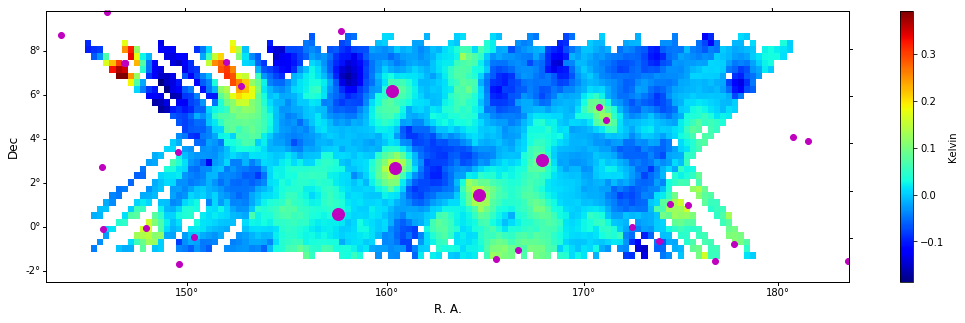

In [14]:
plt.figure(figsize=(18,5))
plt.subplot(projection=w2)
plt.imshow(cube[:,:,ch_plot].T,cmap='jet',aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.plot(ptr_ra_pix[23],ptr_dec_pix[23],'mo',ms=12)
plt.plot(ptr_ra_pix[26],ptr_dec_pix[26],'mo',ms=12)
plt.plot(ptr_ra_pix[21],ptr_dec_pix[21],'mo',ms=12)
plt.plot(ptr_ra_pix[19],ptr_dec_pix[19],'mo',ms=12)
plt.colorbar(label='Kelvin')
plt.xlabel('R. A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.show()

# show examples for rfi filter

In [15]:
#limit related para
print pix_deg, std_sigma, i_iter

0.3 2.5 2


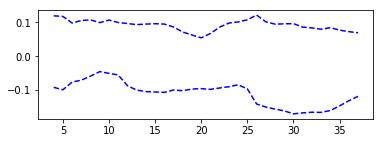

In [16]:
plt.figure(figsize=(6,2))
plt.plot(Tresi_ra_l[:,ch_plot],'b--')
plt.plot(Tresi_ra_u[:,ch_plot],'b--')
plt.show()

-------------------------------------------
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : 143.0  -2.5  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 4096  41  133
-------------------------------------------
***stastic cubes initialized
# cube 1: 1551037708 m061


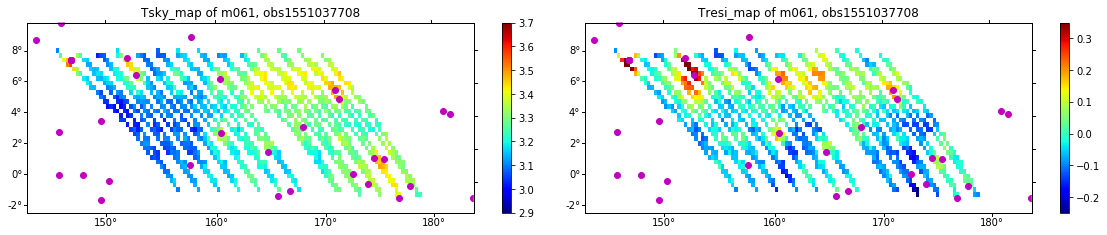

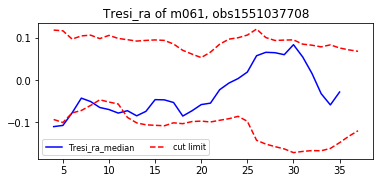

***1009 channels deleted
# cube 2: 1551055211 m061


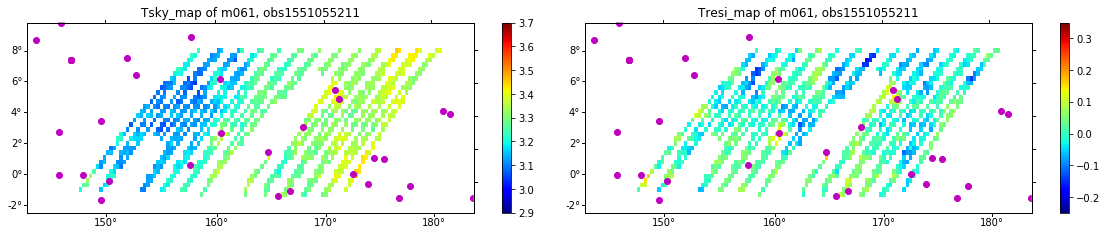

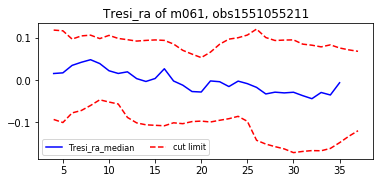

***3 channels deleted


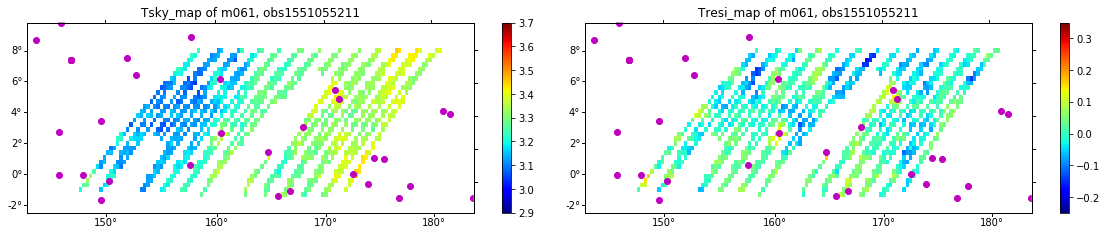

# cube 3: 1553966342 m061


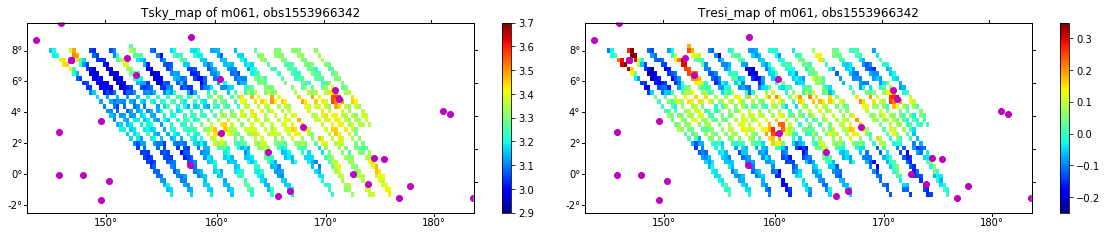

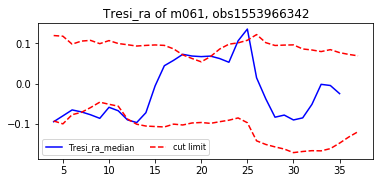

***1320 channels deleted
# cube 4: 1554156377 m061


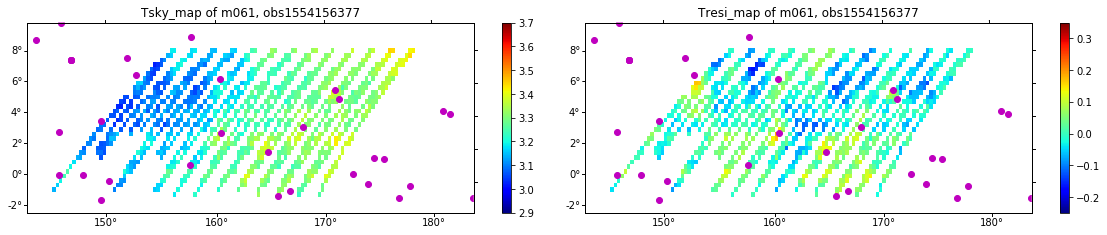

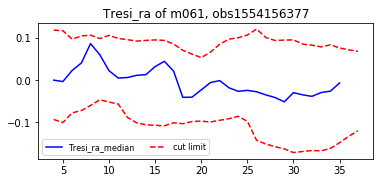

***309 channels deleted


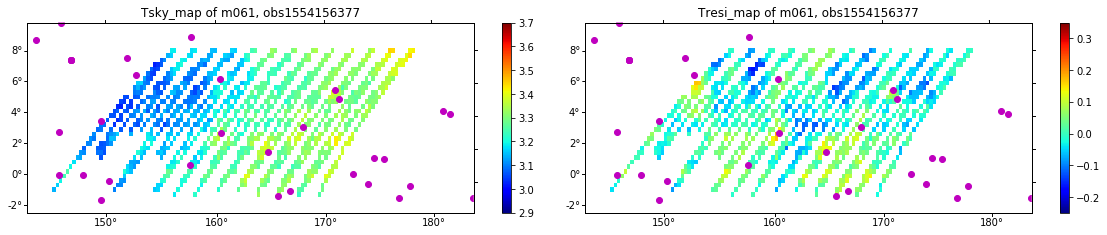

# cube 5: 1556052116 m061


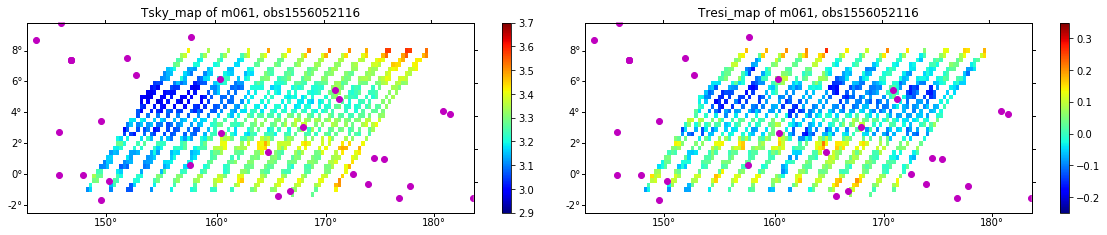

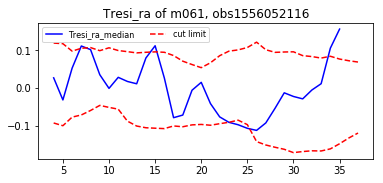

***1059 channels deleted
# cube 6: 1556138397 m061


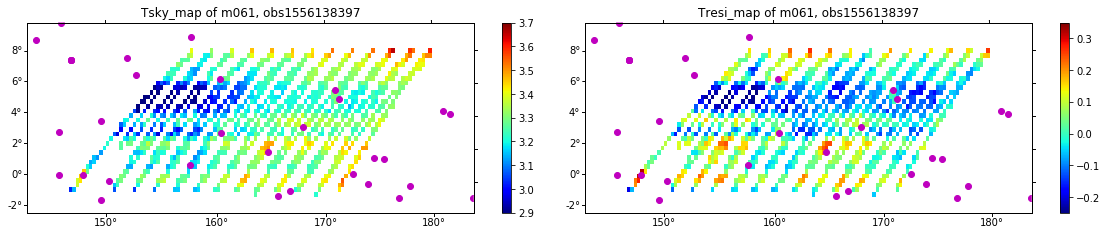

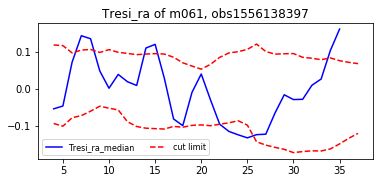

***1314 channels deleted
# cube 7: 1562857793 m061


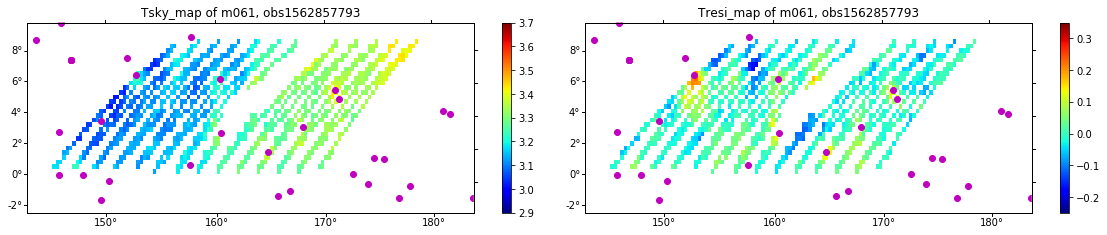

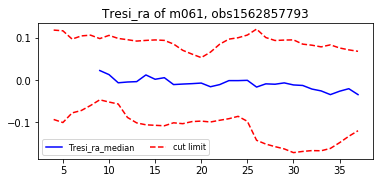

***44 channels deleted


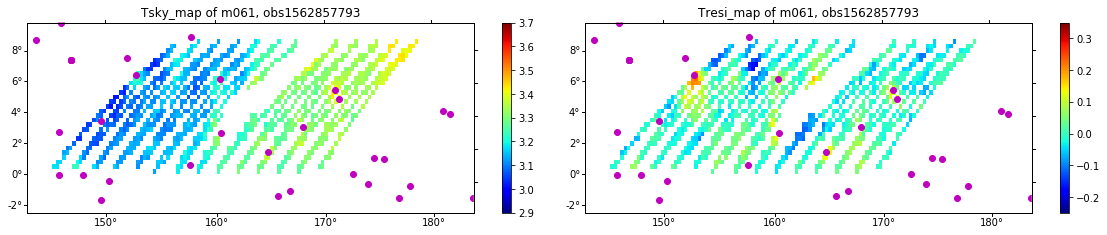

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:120: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:121: RuntimeWarning: invalid value encountered in divide


3.0539318819 0.174712757355
5.30158228322e-05 0.043679391179
3.24121762551 0.0973889682925
-0.000313429708269 0.0522748039949


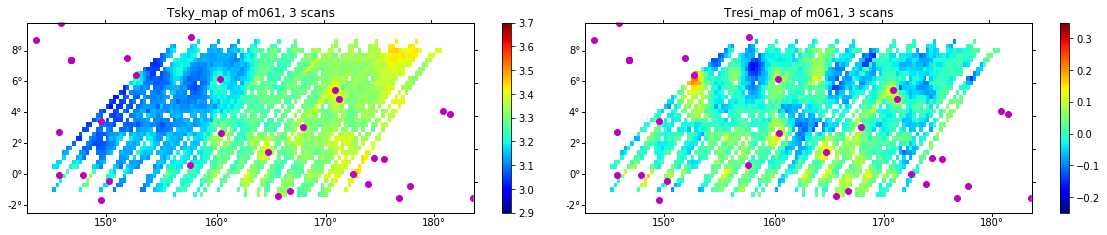

In [17]:

d_count1=0 #cube count
d_count_plot1=0 #channel count

for a_i in range(61,62):
    ant='m'+ "%03d" % a_i
    #print ant
    
    for f_i in range(len(fname_list)):
        fname=fname_list[f_i]
        #print fname
        
        try:

            Fits1='/idia/projects/hi_im/raw_vis/katcali_output/level5_output/p'+str(pix_deg)+'d/Tmap/'+fname+'_'+ant+'_Tsky_xy_p'+str(pix_deg)+'d.fits'
            Tsky_cube = fits.open(Fits1)[0].data
            Fits2='/idia/projects/hi_im/raw_vis/katcali_output/level5_output/p'+str(pix_deg)+'d/Tmap/'+fname+'_'+ant+'_Tresi_xy_p'+str(pix_deg)+'d.fits'
            Tresi_cube = fits.open(Fits2)[0].data
            assert(np.shape(Tsky_cube)==np.shape(Tresi_cube))
            assert((np.isnan(Tresi_cube)).all()==False)
            d_count1+=1 #cube count
            
            if (d_count1==1):
                Npix_x= np.shape(Tsky_cube)[0]
                Npix_y= np.shape(Tsky_cube)[1]

                w=WCS(Fits1).dropaxis(-1)
                w2=WCS(Fits2).dropaxis(-1)
                assert(w.wcs==w2.wcs)
                print '-------------------------------------------'
                print w
                print '-------------------------------------------'
                fits_temp=np.zeros([Npix_x,Npix_y,4096])

                Sum_Tsky_xy=fits_temp.copy()
                Sum_Tresi_xy=fits_temp.copy()
                Npix_xy_count1=fits_temp.copy()
                Npix_xy_count2=fits_temp.copy()

                print '***stastic cubes initialized'
                
            print '# cube '+str(d_count1)+': '+fname+' '+ant
            assert(np.shape(Tsky_cube)==np.shape(Sum_Tsky_xy))
            
            plt.figure(figsize=(20,3.5))
            plt.subplots_adjust (wspace=0, hspace=0.1)
            plt.subplot(121,projection=w)
            plt.imshow(Tsky_cube[:,:,ch_plot].T, aspect='auto',cmap='jet',vmin=2.9,vmax=3.7)
            plt.title('Tsky_map of '+ant+', obs'+fname, fontsize=12)
            plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
            plt.xlim([0,Npix_x])
            plt.ylim([0,Npix_y])
            plt.colorbar()

            plt.subplot(122,projection=w)
            plt.imshow(Tresi_cube[:,:,ch_plot].T, aspect='auto',cmap='jet',vmin=-0.25,vmax=0.35)
            plt.title('Tresi_map of '+ant+', obs'+fname, fontsize=12)
            plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
            plt.xlim([0,Npix_x])
            plt.ylim([0,Npix_y])
            plt.colorbar()
            plt.show()         
            
            #mean along dec to check rfi lines
            Tresi_cube1=Tresi_cube.copy()
            Tresi_cube1[pix_ma_ra,pix_ma_dec,:]=np.nan
            Tresi_ra_median=np.nanmedian(Tresi_cube1,axis=0) #always check Tresi since Tsky have the Galactic slope 
            
            ch_drop=[]  
            for ch_i in range(4096):
                if ((Tresi_ra_median[:,ch_i]<Tresi_ra_l[:,ch_i]).any()==True 
                    or (Tresi_ra_median[:,ch_i]>Tresi_ra_u[:,ch_i]).any()==True):
                    ch_drop.append(ch_i)
            plt.figure(figsize=(6,2.5))
            plt.plot(Tresi_ra_median[:,ch_plot],'b')
            plt.plot(Tresi_ra_l[:,ch_plot],'r--')
            plt.plot(Tresi_ra_u[:,ch_plot],'r--')
            plt.legend(['Tresi_ra_median','cut limit'], ncol=2, fontsize=8)
            plt.title('Tresi_ra of '+ant+', obs'+fname, fontsize=12)
            plt.show()
            
            if len(ch_drop)>0:
                Tsky_cube[:,:,ch_drop]=np.nan            
                Tresi_cube[:,:,ch_drop]=np.nan
                print '***'+str(len(ch_drop))+' channels deleted'
                
            if  np.isnan(Tsky_cube[:,:,ch_plot]).all()==False:  
                
                plt.figure(figsize=(20,3.5))
                plt.subplots_adjust (wspace=0, hspace=0.1)

                plt.subplot(121,projection=w)
                plt.imshow(Tsky_cube[:,:,ch_plot].T, aspect='auto',cmap='jet',vmin=2.9,vmax=3.7)
                plt.title('Tsky_map of '+ant+', obs'+fname, fontsize=12)
                plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
                plt.xlim([0,Npix_x])
                plt.ylim([0,Npix_y])
                plt.colorbar()

                plt.subplot(122,projection=w)
                plt.imshow(Tresi_cube[:,:,ch_plot].T, aspect='auto',cmap='jet',vmin=-0.25,vmax=0.35)
                plt.title('Tresi_map of '+ant+', obs'+fname, fontsize=12)
                plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
                plt.xlim([0,Npix_x])
                plt.ylim([0,Npix_y])
                plt.colorbar()
                plt.show()            

            
            Sum_Tsky_xy[~np.isnan(Tsky_cube)]+=Tsky_cube[~np.isnan(Tsky_cube)]
            Sum_Tresi_xy[~np.isnan(Tresi_cube)]+=Tresi_cube[~np.isnan(Tresi_cube)]
            Npix_xy_count1[~np.isnan(Tsky_cube)]+=1
            Npix_xy_count2[~np.isnan(Tresi_cube)]+=1
            if (np.isnan(Tsky_cube[:,:,ch_plot])).all()==False: #channel count
                d_count_plot1+=1
            
        except IOError:
            print 'no data cube for '+ fname+', '+ant

    Tsky_xy=Sum_Tsky_xy/Npix_xy_count1
    Tresi_xy=Sum_Tresi_xy/Npix_xy_count2

    print np.nanmean(Tsky_xy),np.nanstd(Tsky_xy)
    print np.nanmean(Tresi_xy),np.nanstd(Tresi_xy)
    print np.nanmean(Tsky_xy[:,:,ch_plot]),np.nanstd(Tsky_xy[:,:,ch_plot])
    print np.nanmean(Tresi_xy[:,:,ch_plot]),np.nanstd(Tresi_xy[:,:,ch_plot])
    Tresi_xy1=Tresi_xy.copy()
    Tresi_xy1[pix_ma_ra,pix_ma_dec,:]=np.nan
    Tresi_ra_median=np.nanmedian(Tresi_xy1,axis=0) #always check Tresi since Tsky have the Galactic slope 
        
    ###make 64 subplot#########
    plt.figure(figsize=(20,3.5))
    plt.subplots_adjust (wspace=0, hspace=0.1)
     
    plt.subplot(121,projection=w)
    plt.imshow(Tsky_xy[:,:,ch_plot].T, aspect='auto',cmap='jet',vmin=2.9,vmax=3.7)
    plt.title('Tsky_map of '+ant+', '+str(d_count_plot1)+ ' scans', fontsize=12)
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    plt.colorbar()
    
    plt.subplot(122,projection=w)
    plt.imshow(Tresi_xy[:,:,ch_plot].T, aspect='auto',cmap='jet',vmin=-0.25,vmax=0.35)
    plt.title('Tresi_map of '+ant+', '+str(d_count_plot1)+ ' scans', fontsize=12)
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    plt.colorbar()
    plt.show()
    
    #reset for each dish
    d_count1=0
    d_count_plot1=0


# the Galactic model

In [18]:
nside=64 #healpix nside, 64: Mean Spacing (deg) is 0.9161
import pysm
from pysm.nominal import models


In [19]:
def cal_Gal_pix (pix_ra, pix_dec, freq, nside):
    sky_config = {
        'synchrotron': models("s1", nside),
    }

    sky = pysm.Sky(sky_config)
    
    c = SkyCoord(ra=pix_ra * u.degree, dec=pix_dec * u.degree, frame='icrs')
    theta = 90 - (c.galactic.b / u.degree).value
    phi = (c.galactic.l / u.degree).value
        
    syn = sky.synchrotron(nu=freq/1e9) / 1e6  # K
    I = hp.pixelfunc.get_interp_val(syn[0, :], theta / 180 * np.pi, phi / 180 * np.pi)
        
    return I


In [20]:
#a=np.where(~np.isnan(Tsky_xy[:,:,ch_plot]))
a=np.where(~np.isnan(cube[:,:,ch_plot]))

pix_list_x=np.array(a[0])
pix_list_y=np.array(a[1])

In [21]:
pix_radec=pixel_to_skycoord(pix_list_x,pix_list_y,w)
pix_ra,pix_dec=(pix_radec.ra/u.deg).value,(pix_radec.dec/u.deg).value

In [22]:
gal_pix=np.zeros([Npix_x,Npix_y])
gal_pix[np.isnan(cube[:,:,ch_plot])]=np.nan
gal_pix[pix_list_x,pix_list_y]=cal_Gal_pix (pix_ra, pix_dec, cal_freq(ch_plot), nside)    


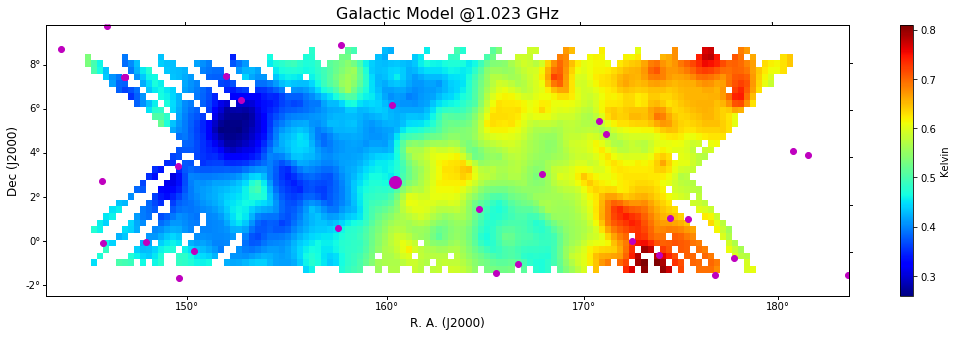

In [23]:
plt.figure(figsize=(18,5))
plt.subplot(projection=w)
plt.imshow(gal_pix.T,cmap='jet',aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)

plt.colorbar(label='Kelvin')
plt.xlabel('R. A. (J2000)',fontsize=12)
plt.ylabel('Dec (J2000)',fontsize=12)
plt.title('Galactic Model @'+str(round(cal_freq(ch_plot)/1e9,3))+' GHz',fontsize=16)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
#plt.savefig('Tgal_model'+str(ch_plot)+'.pdf', bbox_inches='tight')
plt.show()

In [24]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Wed Jul  8 21:41:29 2020#
